# Approach_1

In [1]:
import os
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

# ✅ Constants
DATA_DIR = r"C:\Users\T1_Machine\xai_metric\Machine_unlearning\cvip\Reduced_Dataset_600"
BATCH_SIZE = 16
IMAGE_SIZE = 224
NUM_WORKERS = 4  # or 0 if using Windows with no multiprocessing

# ✅ Image transforms
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # normalize between [-1, 1]
])

# ✅ Load full dataset
full_dataset = ImageFolder(DATA_DIR, transform=transform)
CLASS_NAMES = full_dataset.classes
NUM_CLASSES = len(CLASS_NAMES)

print("✅ Classes found:", CLASS_NAMES)


✅ Classes found: ['human', 'mine', 'plane', 'seafloor', 'ship']


In [2]:
# ✅ Split into Train / Val / Test (70/15/15)
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# ✅ DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


In [3]:
import torch
import torchvision.models as models
import torch.nn as nn

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🔧 Create CNN or ViT-based classifier
def create_model(model_name, num_classes, pretrained=True):
    if model_name == 'resnet18':
        model = models.resnet18(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(pretrained=pretrained)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == 'vit_b_16':
        model = models.vit_b_16(pretrained=pretrained)
        model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
    else:
        raise ValueError("Unsupported model type")

    return model.to(DEVICE)


In [4]:
model_names = ['efficientnet_b0']

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import torch.nn.functional as F
import os

MODEL_SAVE_PATH = './saved_models_baseline'
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

def train_and_evaluate(model_name, num_epochs=20):
    print(f"\n🚀 Training Baseline Model: {model_name}")

    model = create_model(model_name, NUM_CLASSES, pretrained=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100. * correct / total
        print(f"📘 Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%")

        # Validation
        val_acc = evaluate_accuracy(model, val_loader)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), os.path.join(MODEL_SAVE_PATH, f'best_{model_name}.pth'))
            print(f"✅ Best model saved at val acc {val_acc:.2f}%")

    print(f"\n🔍 Final Evaluation on Test Set:")
    evaluate_classification_report(model, test_loader, model_name)


In [6]:
def evaluate_accuracy(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100. * correct / total


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_classification_report(model, loader, model_name):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\n🧾 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()



🚀 Training Baseline Model: efficientnet_b0


C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📘 Epoch 1/10 - Loss: 87.8761, Train Acc: 80.97%
✅ Best model saved at val acc 95.11%
📘 Epoch 2/10 - Loss: 20.4805, Train Acc: 96.15%
✅ Best model saved at val acc 98.89%
📘 Epoch 3/10 - Loss: 9.0716, Train Acc: 98.24%
📘 Epoch 4/10 - Loss: 5.3197, Train Acc: 99.05%
📘 Epoch 5/10 - Loss: 4.8318, Train Acc: 99.29%
📘 Epoch 6/10 - Loss: 2.2996, Train Acc: 99.76%
✅ Best model saved at val acc 99.56%
📘 Epoch 7/10 - Loss: 1.5458, Train Acc: 99.86%
📘 Epoch 8/10 - Loss: 2.0951, Train Acc: 99.67%
📘 Epoch 9/10 - Loss: 2.1599, Train Acc: 99.57%
📘 Epoch 10/10 - Loss: 1.5307, Train Acc: 99.71%

🔍 Final Evaluation on Test Set:

🧾 Classification Report:
              precision    recall  f1-score   support

       human       1.00      1.00      1.00        88
        mine       0.99      1.00      0.99        96
       plane       0.98      0.98      0.98        85
    seafloor       1.00      1.00      1.00        87
        ship       0.99      0.98      0.98        95

    accuracy                   

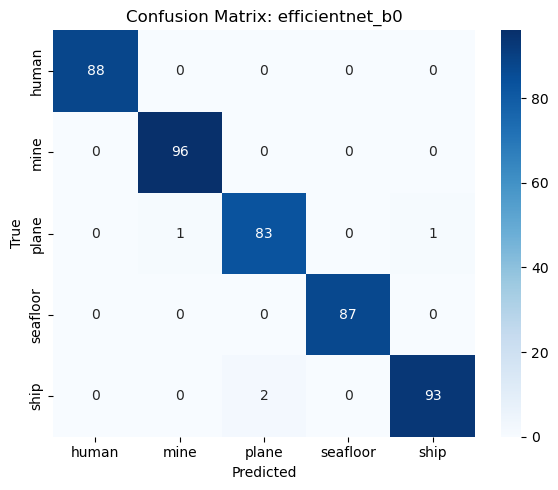

In [8]:
for model_name in model_names:
    train_and_evaluate(model_name, num_epochs=10)


In [9]:
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np

# ✅ Step 1: Preprocess Image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    return img_tensor.to(DEVICE), img

# ✅ Step 2: Load Saved Model
def load_model_for_inference(model_name):
    model = create_model(model_name, NUM_CLASSES, pretrained=False)
    model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, f"best_{model_name}.pth"), map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    return model

# ✅ Step 3: Print Class Prediction & Confidence
def print_prediction(model, input_tensor):
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = F.softmax(outputs, dim=1).squeeze().cpu().numpy()
        top_idx = np.argmax(probs)
        print(f"🧠 Predicted: {CLASS_NAMES[top_idx]} ({probs[top_idx]*100:.2f}%)")


In [10]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
import matplotlib.pyplot as plt

def batch_predict(images, model):
    model.eval()
    images = torch.from_numpy(images).permute(0, 3, 1, 2).float()
    images = F.interpolate(images, size=(224, 224))
    images = (images / 255. - 0.5) / 0.5
    outputs = model(images.to(DEVICE))
    return F.softmax(outputs, dim=1).detach().cpu().numpy()

def explain_with_lime(image_pil, model, model_name):
    explainer = lime_image.LimeImageExplainer()
    image_np = np.array(image_pil.resize((224, 224)))
    
    explanation = explainer.explain_instance(
        image_np,
        lambda x: batch_predict(x, model),
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )
    
    temp, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0],
        positive_only=True,
        hide_rest=True
    )
    
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.title(f"LIME Explanation - {model_name}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\T1_Machine\AppData\Local\Temp\ipykernel_6116\2233540322.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future relea


🔍 EFFICIENTNET_B0 — Prediction + Explainability
🧠 Predicted: plane (99.95%)


  0%|          | 0/1000 [00:00<?, ?it/s]

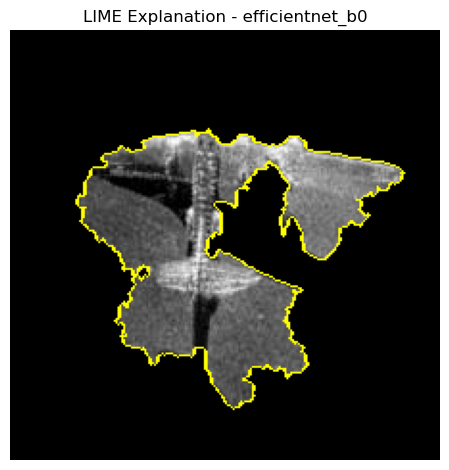

In [11]:
image_path = r"D:\datasets\Reduced_Dataset_600\plane\shuffled_28_1 (1385).jpg"

for model_name in model_names:
    input_tensor, image_pil = preprocess_image(image_path)
    model = load_model_for_inference(model_name)

    print(f"\n🔍 {model_name.upper()} — Prediction + Explainability")
    print_prediction(model, input_tensor)
    explain_with_lime(image_pil, model, model_name)


In [12]:
import random
import time
from torch.utils.data import Dataset, DataLoader
from torch.nn import TripletMarginLoss
from collections import Counter

class TripletSonarDataset(Dataset):
    def __init__(self, dataset):
        print("🔧 Initializing TripletSonarDataset...")
        self.dataset = dataset
        self.class_to_indices = {}
        for idx, (_, label) in enumerate(dataset):
            self.class_to_indices.setdefault(label, []).append(idx)
        
        # Debug: Print class distribution
        for label, indices in self.class_to_indices.items():
            class_name = CLASS_NAMES[label] if 'CLASS_NAMES' in globals() else f"Class_{label}"
            print(f"  {class_name}: {len(indices)} samples")
            if len(indices) == 1:
                print(f"  ⚠️ WARNING: {class_name} has only 1 sample!")
        print("✅ TripletSonarDataset initialized")
    
    def __getitem__(self, index):
        start_time = time.time()
        
        # Debug: Print every 100th item
        if index % 100 == 0:
            print(f"🔄 Getting item {index}")
        
        try:
            anchor_img, anchor_label = self.dataset[index]
            
            # Positive: same class
            positive_candidates = self.class_to_indices[anchor_label]
            
            if len(positive_candidates) == 1:
                positive_index = positive_candidates[0]
            else:
                positive_index = random.choice(positive_candidates)
                attempts = 0
                while positive_index == index and attempts < 10:  # Prevent infinite loop
                    positive_index = random.choice(positive_candidates)
                    attempts += 1
                if attempts >= 10:
                    print(f"⚠️ Warning: Could not find different positive sample for index {index}")
            
            positive_img, _ = self.dataset[positive_index]
            
            # Negative: seafloor
            seabed_label = CLASS_NAMES.index("seafloor") if 'CLASS_NAMES' in globals() else 0
            if seabed_label not in self.class_to_indices:
                print(f"❌ ERROR: Seafloor label {seabed_label} not found in class_to_indices")
                # Fallback: use any other class
                available_labels = list(self.class_to_indices.keys())
                negative_label = [l for l in available_labels if l != anchor_label][0]
                negative_index = random.choice(self.class_to_indices[negative_label])
            else:
                negative_index = random.choice(self.class_to_indices[seabed_label])
            
            negative_img, _ = self.dataset[negative_index]
            
            # Debug: Check if data loading is slow
            elapsed = time.time() - start_time
            if elapsed > 1.0:  # If single item takes more than 1 second
                print(f"⏰ Slow data loading: item {index} took {elapsed:.2f}s")
            
            return anchor_img, positive_img, negative_img, anchor_label
            
        except Exception as e:
            print(f"❌ Error in __getitem__ at index {index}: {e}")
            raise e
    
    def __len__(self):
        return len(self.dataset)


def train_unlearning_model(model_name, num_epochs=20):
    print(f"\n🚀 Training Triplet Contrastive Unlearning: {model_name}")
    
    # Debug: Test model creation
    print("🔧 Creating model...")
    model = create_model(model_name, NUM_CLASSES, pretrained=True)
    model.to(DEVICE)
    print("✅ Model created and moved to device")
    
    # Debug: Test loss functions
    print("🔧 Creating loss functions...")
    criterion_cls = nn.CrossEntropyLoss()
    criterion_triplet = TripletMarginLoss(margin=1.0, p=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    print("✅ Loss functions created")
    
    # Debug: Test dataset creation
    print("🔧 Creating triplet dataset...")
    triplet_dataset = TripletSonarDataset(train_dataset)
    print(f"✅ Triplet dataset created with {len(triplet_dataset)} samples")
    
    # Debug: Test a few samples manually
    print("🔧 Testing dataset samples...")
    for i in range(min(3, len(triplet_dataset))):
        try:
            sample_start = time.time()
            anchor, positive, negative, label = triplet_dataset[i]
            sample_time = time.time() - sample_start
            print(f"  Sample {i}: shapes={anchor.shape}, {positive.shape}, {negative.shape}, label={label}, time={sample_time:.3f}s")
        except Exception as e:
            print(f"  ❌ Error loading sample {i}: {e}")
            return None
    
    # Debug: Test dataloader creation
    print("🔧 Creating data loader...")
    try:
        triplet_loader = DataLoader(
            triplet_dataset, 
            batch_size=min(BATCH_SIZE, 4),  # Start with small batch size
            shuffle=True, 
            num_workers=0,  # Set to 0 for debugging
            pin_memory=False  # Disable for debugging
        )
        print(f"✅ Data loader created with batch_size={min(BATCH_SIZE, 4)}")
    except Exception as e:
        print(f"❌ Error creating data loader: {e}")
        return None
    
    # Debug: Test first batch
    print("🔧 Testing first batch...")
    try:
        batch_start = time.time()
        first_batch = next(iter(triplet_loader))
        batch_time = time.time() - batch_start
        anchor, positive, negative, labels = first_batch
        print(f"✅ First batch loaded successfully in {batch_time:.2f}s")
        print(f"  Batch shapes: anchor={anchor.shape}, positive={positive.shape}, negative={negative.shape}, labels={labels.shape}")
    except Exception as e:
        print(f"❌ Error loading first batch: {e}")
        return None
    
    # Debug: Test model forward pass
    print("🔧 Testing model forward pass...")
    try:
        model.eval()
        with torch.no_grad():
            anchor_gpu = anchor.to(DEVICE)
            forward_start = time.time()
            logits = model(anchor_gpu)
            forward_time = time.time() - forward_start
            print(f"✅ Forward pass successful in {forward_time:.3f}s, output shape: {logits.shape}")
    except Exception as e:
        print(f"❌ Error in forward pass: {e}")
        return None
    
    # Debug: Test feature extraction
    print("🔧 Testing feature extraction...")
    try:
        feat_start = time.time()
        feat_anchor = extract_features(model, anchor_gpu)
        feat_time = time.time() - feat_start
        print(f"✅ Feature extraction successful in {feat_time:.3f}s, feature shape: {feat_anchor.shape}")
    except Exception as e:
        print(f"❌ Error in feature extraction: {e}")
        return None
    
    # If we get here, start actual training
    print("\n🎯 All checks passed! Starting actual training...")
    
    label_counts = Counter([label for _, label in train_dataset])
    print("🧾 Class distribution in training set:", {CLASS_NAMES[k]: v for k, v in label_counts.items()})
    
    for epoch in range(num_epochs):
        print(f"\n▶️ Starting epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        
        epoch_start = time.time()
        
        # Add timeout for batches
        for i, (anchor, positive, negative, labels) in enumerate(triplet_loader):
            batch_start = time.time()
            
            if i % 10 == 0:  # Print every 10th batch
                print(f"🌀 Processing batch {i+1}/{len(triplet_loader)}")
            
            try:
                anchor, positive, negative, labels = anchor.to(DEVICE), positive.to(DEVICE), negative.to(DEVICE), labels.to(DEVICE)
                
                # Classification
                logits = model(anchor)
                loss_cls = criterion_cls(logits, labels)
                
                # Feature extraction
                feat_anchor = extract_features(model, anchor)
                feat_pos = extract_features(model, positive)
                feat_neg = extract_features(model, negative)
                
                loss_triplet = criterion_triplet(feat_anchor, feat_pos, feat_neg)
                loss = loss_cls + loss_triplet
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                batch_time = time.time() - batch_start
                if batch_time > 10.0:  # If batch takes more than 10 seconds
                    print(f"⏰ Slow batch {i}: {batch_time:.2f}s")
                    
            except Exception as e:
                print(f"❌ Error in batch {i}: {e}")
                break
                
            # Emergency break if epoch is taking too long
            if time.time() - epoch_start > 3600:  # 1 hour timeout
                print("⏰ Epoch timeout reached, breaking...")
                break
        
        acc = 100. * correct / total if total > 0 else 0
        epoch_time = time.time() - epoch_start
        print(f"📘 Epoch {epoch+1}/{num_epochs} — Loss: {running_loss:.4f}, Accuracy: {acc:.2f}%, Time: {epoch_time:.1f}s")
    
    # Save model
    save_path = os.path.join(MODEL_SAVE_PATH, f"model_unlearned_{model_name}.pth")
    torch.save(model.state_dict(), save_path)
    print(f"✅ Model saved: {save_path}")
    return model


# Replace your original training call with this debug version:
# model_unlearned = train_unlearning_model_debug(model_name, num_epochs=10)

In [13]:
def evaluate_unlearned(model, model_name):
    print(f"\n📊 Evaluation Report for {model_name} (Unlearned):")
    evaluate_classification_report(model, test_loader, f"{model_name}_unlearned")


In [14]:
def run_full_explanation(image_path, model_name):
    input_tensor, image_pil = preprocess_image(image_path)

    # Baseline model f(x)
    model_f = load_model_for_inference(model_name)
    print(f"\n🧠 {model_name} (Baseline)")
    print_prediction(model_f, input_tensor)

    # Unlearned model f_u(x)
    model_fu = create_model(model_name, NUM_CLASSES, pretrained=False)
    model_fu.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, f"model_unlearned_{model_name}.pth"), map_location=DEVICE))
    model_fu.to(DEVICE)
    model_fu.eval()
    print(f"\n🧠 {model_name} (Unlearned)")
    print_prediction(model_fu, input_tensor)

    # Compute and visualize E_final
    compute_e_final(input_tensor, model_f, model_fu, image_pil)


In [15]:
def compute_e_final(image_tensor, model_f, model_fu, image_pil):
    from lime import lime_image
    from skimage.segmentation import mark_boundaries

    explainer = lime_image.LimeImageExplainer()
    image_np = image_pil.resize((224, 224))
    image_np = np.array(image_np)

    def batch_predict(images, model):
        images = torch.from_numpy(images).permute(0, 3, 1, 2).float()
        images = F.interpolate(images, size=(224, 224))
        images = (images / 255. - 0.5) / 0.5
        outputs = model(images.to(DEVICE))
        return F.softmax(outputs, dim=1).detach().cpu().numpy()

    exp_f = explainer.explain_instance(image_np, lambda x: batch_predict(x, model_f), top_labels=1, num_samples=1000)
    exp_fu = explainer.explain_instance(image_np, lambda x: batch_predict(x, model_fu), top_labels=1, num_samples=1000)

    img_f, mask_f = exp_f.get_image_and_mask(exp_f.top_labels[0], positive_only=True, hide_rest=True)
    img_fu, mask_fu = exp_fu.get_image_and_mask(exp_fu.top_labels[0], positive_only=True, hide_rest=True)

    # Compute E_final
    subtracted = (mask_f.astype(float) - mask_fu.astype(float)).clip(0, 1)

    from skimage.color import label2rgb

    # Set contrasting background color (e.g., dark blue)
    bg_color = (0, 0, 128)  # RGB for dark navy blue
    
    # Replace black (0,0,0) in img_f and img_fu with bg_color
    img_f_bg = np.where(img_f == [0, 0, 0], bg_color, img_f).astype(np.uint8)
    img_fu_bg = np.where(img_fu == [0, 0, 0], bg_color, img_fu).astype(np.uint8)

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    
    axs[0].imshow(image_np, cmap='gray')
    axs[0].set_title("Original")
    
    axs[1].imshow(mark_boundaries(img_f_bg, mask_f))
    axs[1].set_title("LIME: f(x)")
    
    axs[2].imshow(mark_boundaries(img_fu_bg, mask_fu))
    axs[2].set_title("LIME: f_u(x)")
    
    axs[3].imshow(subtracted, cmap='jet')
    axs[3].set_title("E_final = f(x) - f_u(x)")
    
    for ax in axs:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()




In [16]:
# 🔍 Extract intermediate features (for contrastive loss)
def extract_features(model, x):
    model.eval()
    with torch.no_grad():
        if hasattr(model, 'forward_features'):
            feats = model.forward_features(x)  # ViT, EfficientNet
        elif hasattr(model, 'features'):  # For models like MobileNet
            feats = model.features(x)
        else:  # Fallback for ResNet
            x = model.conv1(x)
            x = model.bn1(x)
            x = model.relu(x)
            x = model.layer1(x)
            x = model.layer2(x)
            x = model.layer3(x)
            x = model.layer4(x)
            x = model.avgpool(x)
            feats = x
        return feats.view(feats.size(0), -1)



🔁 Processing Backbone: EFFICIENTNET_B0

🚀 Training Triplet Contrastive Unlearning: efficientnet_b0
🔧 Creating model...
✅ Model created and moved to device
🔧 Creating loss functions...
✅ Loss functions created
🔧 Creating triplet dataset...
🔧 Initializing TripletSonarDataset...


C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  seafloor: 420 samples
  human: 423 samples
  ship: 420 samples
  plane: 424 samples
  mine: 415 samples
✅ TripletSonarDataset initialized
✅ Triplet dataset created with 2102 samples
🔧 Testing dataset samples...
🔄 Getting item 0
  Sample 0: shapes=torch.Size([3, 224, 224]), torch.Size([3, 224, 224]), torch.Size([3, 224, 224]), label=3, time=0.007s
  Sample 1: shapes=torch.Size([3, 224, 224]), torch.Size([3, 224, 224]), torch.Size([3, 224, 224]), label=3, time=0.004s
  Sample 2: shapes=torch.Size([3, 224, 224]), torch.Size([3, 224, 224]), torch.Size([3, 224, 224]), label=0, time=0.008s
🔧 Creating data loader...
✅ Data loader created with batch_size=4
🔧 Testing first batch...
✅ First batch loaded successfully in 0.11s
  Batch shapes: anchor=torch.Size([4, 3, 224, 224]), positive=torch.Size([4, 3, 224, 224]), negative=torch.Size([4, 3, 224, 224]), labels=torch.Size([4])
🔧 Testing model forward pass...
✅ Forward pass successful in 0.036s, output shape: torch.Size([4, 5])
🔧 Testing feature

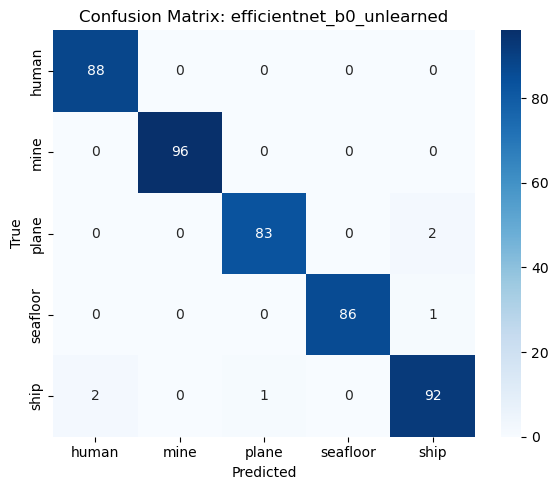

C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\T1_Machine\AppData\Local\Temp\ipykernel_6116\2233540322.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future relea


🧠 efficientnet_b0 (Baseline)
🧠 Predicted: plane (99.95%)

🧠 efficientnet_b0 (Unlearned)
🧠 Predicted: plane (100.00%)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

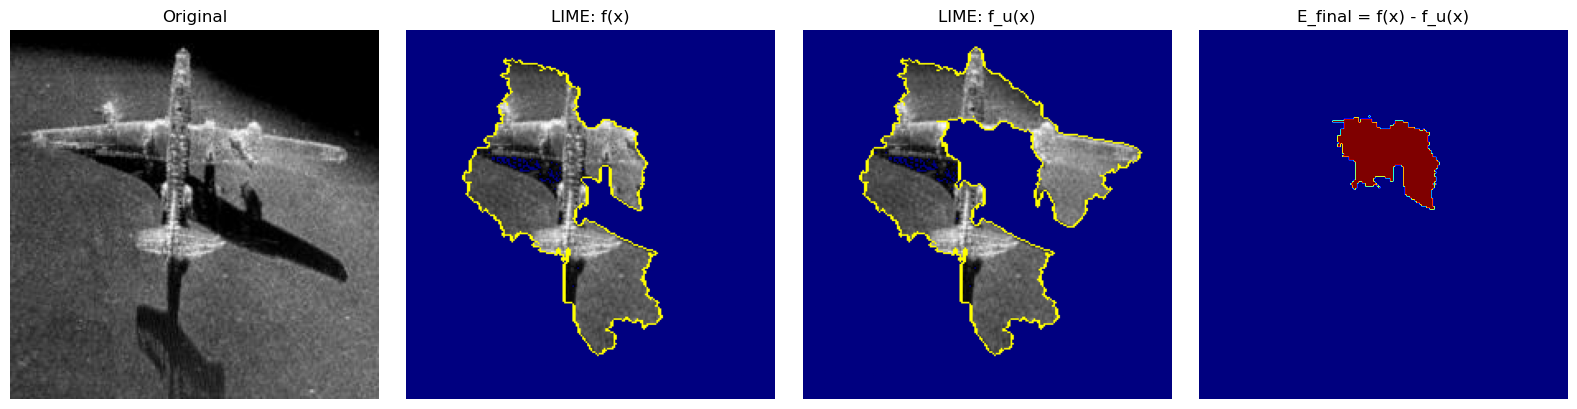

In [17]:
# ✅ Define your backbones
model_names = ["efficientnet_b0"]

# ✅ Your test image path
test_image_path = r"D:\datasets\Reduced_Dataset_600\plane\shuffled_28_1 (1385).jpg"

# ✅ Loop through each model
for model_name in model_names:
    print(f"\n🔁 Processing Backbone: {model_name.upper()}")

    # 1️⃣ Train Triplet-Based Unlearning Model
    model_unlearned = train_unlearning_model(model_name, num_epochs=20)

    # 2️⃣ Evaluate and show classification report + confusion matrix
    evaluate_unlearned(model_unlearned, model_name)

    # 3️⃣ Run LIME-based visual explanation and E_final
    run_full_explanation(test_image_path, model_name)



🔁 Processing Backbone: EFFICIENTNET_B0


C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\T1_Machine\AppData\Local\Temp\ipykernel_6116\2233540322.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future relea


🧠 efficientnet_b0 (Baseline)
🧠 Predicted: ship (99.98%)


C:\Users\T1_Machine\AppData\Local\Temp\ipykernel_6116\3836711057.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_fu.load_state_dict(torch.load(os.path.join(MODEL_


🧠 efficientnet_b0 (Unlearned)
🧠 Predicted: human (99.27%)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

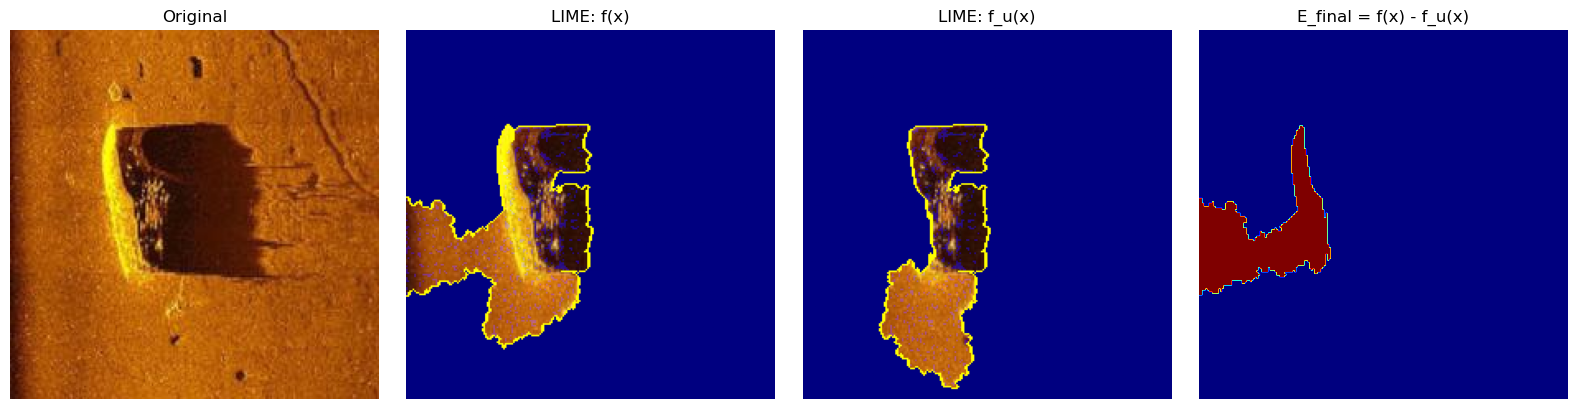

In [22]:
# ✅ Define your backbones
model_names = ["efficientnet_b0"]

# ✅ Your test image path
test_image_path = r"C:\Users\T1_Machine\xai_metric\Machine_unlearning\cvip\Reduced_Dataset_600\ship\shuffled_400_image_180.jpg"
# ✅ Loop through each model
for model_name in model_names:
    print(f"\n🔁 Processing Backbone: {model_name.upper()}")

    # 1️⃣ Train Triplet-Based Unlearning Model
    # model_unlearned = train_unlearning_model(model_name, num_epochs=20)

    # 2️⃣ Evaluate and show classification report + confusion matrix
    # evaluate_unlearned(model_unlearned, model_name)

    # 3️⃣ Run LIME-based visual explanation and E_final
    run_full_explanation(test_image_path, model_name)


🔁 Processing Backbone: EFFICIENTNET_B0


C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\T1_Machine\AppData\Local\Temp\ipykernel_6116\2233540322.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future relea


🧠 efficientnet_b0 (Baseline)
🧠 Predicted: plane (99.98%)


C:\Users\T1_Machine\AppData\Local\Temp\ipykernel_6116\3836711057.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_fu.load_state_dict(torch.load(os.path.join(MODEL_


🧠 efficientnet_b0 (Unlearned)
🧠 Predicted: plane (99.99%)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

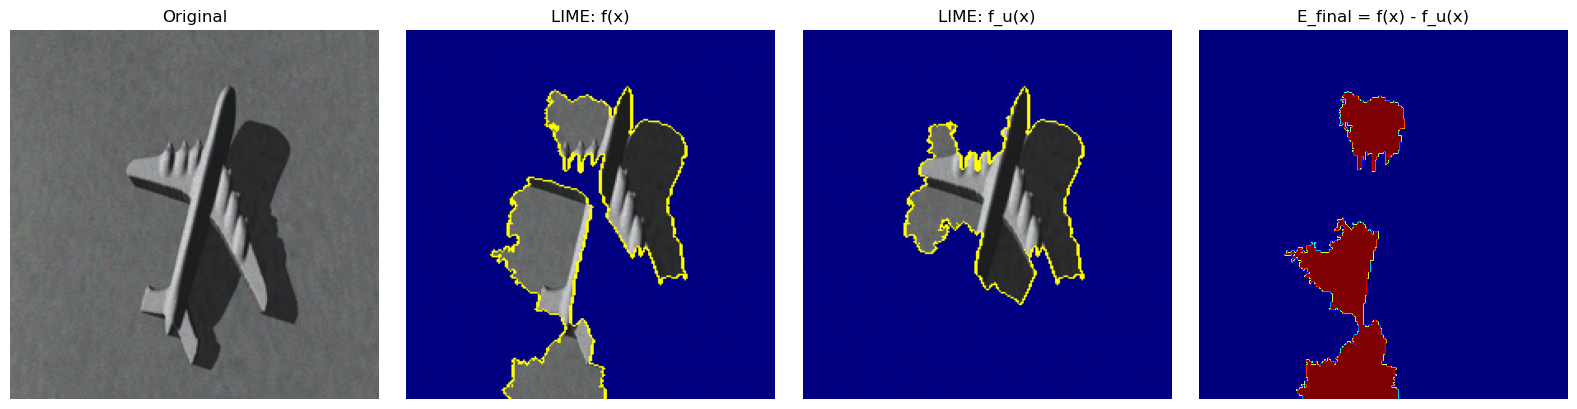

In [24]:
# ✅ Define your backbones
model_names = ["efficientnet_b0"]

# ✅ Your test image path
test_image_path = r"C:\Users\T1_Machine\xai_metric\Machine_unlearning\cvip\Reduced_Dataset_600\plane\shuffled_62_1 (39).jpg"
# ✅ Loop through each model
for model_name in model_names:
    print(f"\n🔁 Processing Backbone: {model_name.upper()}")

    # 1️⃣ Train Triplet-Based Unlearning Model
    # model_unlearned = train_unlearning_model(model_name, num_epochs=20)

    # 2️⃣ Evaluate and show classification report + confusion matrix
    # evaluate_unlearned(model_unlearned, model_name)

    # 3️⃣ Run LIME-based visual explanation and E_final
    run_full_explanation(test_image_path, model_name)

# Approach 2

In [25]:
import os
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

# ✅ Constants
DATA_DIR = r"D:\CVIP\machine_unlearning\SeabedObjects-KLSG--II\SeabedObjects-KLSG--II"
BATCH_SIZE = 16
IMAGE_SIZE = 224
NUM_WORKERS = 4  # or 0 if using Windows with no multiprocessing

# ✅ Image transforms
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # normalize between [-1, 1]
])

# ✅ Load full dataset
full_dataset = ImageFolder(DATA_DIR, transform=transform)
CLASS_NAMES = full_dataset.classes
NUM_CLASSES = len(CLASS_NAMES)

print("✅ Classes found:", CLASS_NAMES)


✅ Classes found: ['mine', 'plane', 'seafloor', 'ship']


In [30]:
# ✅ Split into Train / Val / Test (70/15/15)
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# ✅ DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


In [31]:
import torch
import torchvision.models as models
import torch.nn as nn

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🔧 Create CNN or ViT-based classifier
def create_model(model_name, num_classes, pretrained=True):
    if model_name == 'resnet18':
        model = models.resnet18(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(pretrained=pretrained)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == 'vit_b_16':
        model = models.vit_b_16(pretrained=pretrained)
        model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
    else:
        raise ValueError("Unsupported model type")

    return model.to(DEVICE)


In [32]:
model_names = ['efficientnet_b0']

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import torch.nn.functional as F
import os

MODEL_SAVE_PATH = './saved_models_baseline'
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

def train_and_evaluate(model_name, num_epochs=20):
    print(f"\n🚀 Training Baseline Model: {model_name}")

    model = create_model(model_name, NUM_CLASSES, pretrained=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100. * correct / total
        print(f"📘 Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%")

        # Validation
        val_acc = evaluate_accuracy(model, val_loader)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), os.path.join(MODEL_SAVE_PATH, f'best_{model_name}.pth'))
            print(f"✅ Best model saved at val acc {val_acc:.2f}%")

    print(f"\n🔍 Final Evaluation on Test Set:")
    evaluate_classification_report(model, test_loader, model_name)


In [34]:
def evaluate_accuracy(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100. * correct / total


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_classification_report(model, loader, model_name):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\n🧾 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()



🚀 Training Baseline Model: efficientnet_b0


C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📘 Epoch 1/10 - Loss: 44.5920, Train Acc: 84.57%
✅ Best model saved at val acc 93.98%
📘 Epoch 2/10 - Loss: 14.5992, Train Acc: 93.67%
✅ Best model saved at val acc 96.76%
📘 Epoch 3/10 - Loss: 8.1928, Train Acc: 97.03%
✅ Best model saved at val acc 97.69%
📘 Epoch 4/10 - Loss: 6.1891, Train Acc: 97.92%
✅ Best model saved at val acc 98.15%
📘 Epoch 5/10 - Loss: 5.5063, Train Acc: 98.91%
📘 Epoch 6/10 - Loss: 2.8709, Train Acc: 99.31%
📘 Epoch 7/10 - Loss: 1.3447, Train Acc: 99.80%
📘 Epoch 8/10 - Loss: 1.1608, Train Acc: 99.80%
📘 Epoch 9/10 - Loss: 1.3087, Train Acc: 99.80%
📘 Epoch 10/10 - Loss: 0.7762, Train Acc: 99.90%

🔍 Final Evaluation on Test Set:

🧾 Classification Report:
              precision    recall  f1-score   support

        mine       1.00      1.00      1.00        43
       plane       1.00      0.67      0.80         9
    seafloor       1.00      1.00      1.00        94
        ship       0.96      1.00      0.98        72

    accuracy                           0.99     

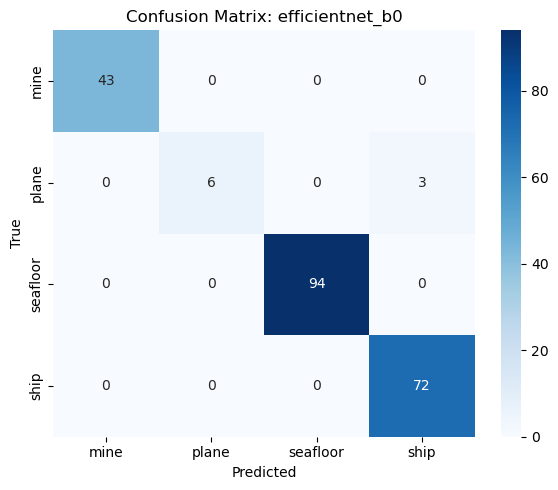

In [36]:
for model_name in model_names:
    train_and_evaluate(model_name, num_epochs=10)


In [37]:
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np

# ✅ Step 1: Preprocess Image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    return img_tensor.to(DEVICE), img

# ✅ Step 2: Load Saved Model
def load_model_for_inference(model_name):
    model = create_model(model_name, NUM_CLASSES, pretrained=False)
    model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, f"best_{model_name}.pth"), map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    return model

# ✅ Step 3: Print Class Prediction & Confidence
def print_prediction(model, input_tensor):
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = F.softmax(outputs, dim=1).squeeze().cpu().numpy()
        top_idx = np.argmax(probs)
        print(f"🧠 Predicted: {CLASS_NAMES[top_idx]} ({probs[top_idx]*100:.2f}%)")


In [38]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
import matplotlib.pyplot as plt

def batch_predict(images, model):
    model.eval()
    images = torch.from_numpy(images).permute(0, 3, 1, 2).float()
    images = F.interpolate(images, size=(224, 224))
    images = (images / 255. - 0.5) / 0.5
    outputs = model(images.to(DEVICE))
    return F.softmax(outputs, dim=1).detach().cpu().numpy()

def explain_with_lime(image_pil, model, model_name):
    explainer = lime_image.LimeImageExplainer()
    image_np = np.array(image_pil.resize((224, 224)))
    
    explanation = explainer.explain_instance(
        image_np,
        lambda x: batch_predict(x, model),
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )
    
    temp, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0],
        positive_only=True,
        hide_rest=True
    )
    
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.title(f"LIME Explanation - {model_name}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\T1_Machine\AppData\Local\Temp\ipykernel_6116\2233540322.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future relea


🔍 EFFICIENTNET_B0 — Prediction + Explainability
🧠 Predicted: mine (84.19%)


  0%|          | 0/1000 [00:00<?, ?it/s]

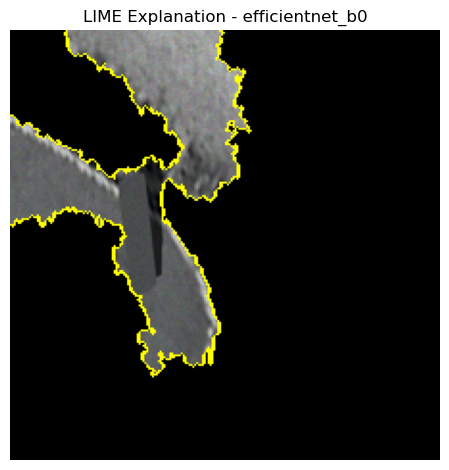

In [41]:
image_path = r"D:\datasets\Sonar_dataset\Sonar_dataset\mine\frame_000413.jpg"

for model_name in model_names:
    input_tensor, image_pil = preprocess_image(image_path)
    model = load_model_for_inference(model_name)

    print(f"\n🔍 {model_name.upper()} — Prediction + Explainability")
    print_prediction(model, input_tensor)
    explain_with_lime(image_pil, model, model_name)


C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\T1_Machine\AppData\Local\Temp\ipykernel_6116\2233540322.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future relea


🔍 EFFICIENTNET_B0 — Prediction + Explainability
🧠 Predicted: mine (99.99%)


  0%|          | 0/1000 [00:00<?, ?it/s]

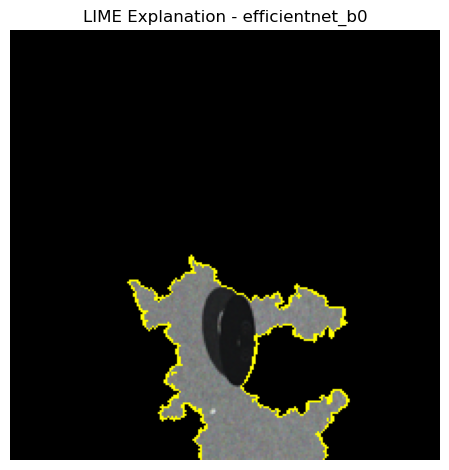

In [42]:
image_path = r"D:\datasets\Sonar_dataset\Sonar_dataset\mine\frame_000693.jpg"

for model_name in model_names:
    input_tensor, image_pil = preprocess_image(image_path)
    model = load_model_for_inference(model_name)

    print(f"\n🔍 {model_name.upper()} — Prediction + Explainability")
    print_prediction(model, input_tensor)
    explain_with_lime(image_pil, model, model_name)


In [43]:
# 🔍 Extract intermediate features (for contrastive loss)
def extract_features(model, x):
    model.eval()
    with torch.no_grad():
        if hasattr(model, 'forward_features'):
            feats = model.forward_features(x)  # ViT, EfficientNet
        elif hasattr(model, 'features'):  # For models like MobileNet
            feats = model.features(x)
        else:  # Fallback for ResNet
            x = model.conv1(x)
            x = model.bn1(x)
            x = model.relu(x)
            x = model.layer1(x)
            x = model.layer2(x)
            x = model.layer3(x)
            x = model.layer4(x)
            x = model.avgpool(x)
            feats = x
        return feats.view(feats.size(0), -1)


In [44]:
import random
import time
from torch.utils.data import Dataset, DataLoader
from torch.nn import TripletMarginLoss
from collections import Counter

class TripletSonarDataset(Dataset):
    def __init__(self, dataset):
        print("🔧 Initializing TripletSonarDataset...")
        self.dataset = dataset
        self.class_to_indices = {}
        for idx, (_, label) in enumerate(dataset):
            self.class_to_indices.setdefault(label, []).append(idx)
        
        # Debug: Print class distribution
        for label, indices in self.class_to_indices.items():
            class_name = CLASS_NAMES[label] if 'CLASS_NAMES' in globals() else f"Class_{label}"
            print(f"  {class_name}: {len(indices)} samples")
            if len(indices) == 1:
                print(f"  ⚠️ WARNING: {class_name} has only 1 sample!")
        print("✅ TripletSonarDataset initialized")
    
    def __getitem__(self, index):
        start_time = time.time()
        
        # Debug: Print every 100th item
        if index % 100 == 0:
            print(f"🔄 Getting item {index}")
        
        try:
            anchor_img, anchor_label = self.dataset[index]
            
            # Positive: same class
            positive_candidates = self.class_to_indices[anchor_label]
            
            if len(positive_candidates) == 1:
                positive_index = positive_candidates[0]
            else:
                positive_index = random.choice(positive_candidates)
                attempts = 0
                while positive_index == index and attempts < 10:  # Prevent infinite loop
                    positive_index = random.choice(positive_candidates)
                    attempts += 1
                if attempts >= 10:
                    print(f"⚠️ Warning: Could not find different positive sample for index {index}")
            
            positive_img, _ = self.dataset[positive_index]
            
            # Negative: seafloor
            seabed_label = CLASS_NAMES.index("seafloor") if 'CLASS_NAMES' in globals() else 0
            if seabed_label not in self.class_to_indices:
                print(f"❌ ERROR: Seafloor label {seabed_label} not found in class_to_indices")
                # Fallback: use any other class
                available_labels = list(self.class_to_indices.keys())
                negative_label = [l for l in available_labels if l != anchor_label][0]
                negative_index = random.choice(self.class_to_indices[negative_label])
            else:
                negative_index = random.choice(self.class_to_indices[seabed_label])
            
            negative_img, _ = self.dataset[negative_index]
            
            # Debug: Check if data loading is slow
            elapsed = time.time() - start_time
            if elapsed > 1.0:  # If single item takes more than 1 second
                print(f"⏰ Slow data loading: item {index} took {elapsed:.2f}s")
            
            return anchor_img, positive_img, negative_img, anchor_label
            
        except Exception as e:
            print(f"❌ Error in __getitem__ at index {index}: {e}")
            raise e
    
    def __len__(self):
        return len(self.dataset)


def train_unlearning_model(model_name, num_epochs=20):
    print(f"\n🚀 Training Triplet Contrastive Unlearning: {model_name}")
    
    # Debug: Test model creation
    print("🔧 Creating model...")
    model = create_model(model_name, NUM_CLASSES, pretrained=True)
    model.to(DEVICE)
    print("✅ Model created and moved to device")
    
    # Debug: Test loss functions
    print("🔧 Creating loss functions...")
    criterion_cls = nn.CrossEntropyLoss()
    criterion_triplet = TripletMarginLoss(margin=1.0, p=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    print("✅ Loss functions created")
    
    # Debug: Test dataset creation
    print("🔧 Creating triplet dataset...")
    triplet_dataset = TripletSonarDataset(train_dataset)
    print(f"✅ Triplet dataset created with {len(triplet_dataset)} samples")
    
    # Debug: Test a few samples manually
    print("🔧 Testing dataset samples...")
    for i in range(min(3, len(triplet_dataset))):
        try:
            sample_start = time.time()
            anchor, positive, negative, label = triplet_dataset[i]
            sample_time = time.time() - sample_start
            print(f"  Sample {i}: shapes={anchor.shape}, {positive.shape}, {negative.shape}, label={label}, time={sample_time:.3f}s")
        except Exception as e:
            print(f"  ❌ Error loading sample {i}: {e}")
            return None
    
    # Debug: Test dataloader creation
    print("🔧 Creating data loader...")
    try:
        triplet_loader = DataLoader(
            triplet_dataset, 
            batch_size=min(BATCH_SIZE, 4),  # Start with small batch size
            shuffle=True, 
            num_workers=0,  # Set to 0 for debugging
            pin_memory=False  # Disable for debugging
        )
        print(f"✅ Data loader created with batch_size={min(BATCH_SIZE, 4)}")
    except Exception as e:
        print(f"❌ Error creating data loader: {e}")
        return None
    
    # Debug: Test first batch
    print("🔧 Testing first batch...")
    try:
        batch_start = time.time()
        first_batch = next(iter(triplet_loader))
        batch_time = time.time() - batch_start
        anchor, positive, negative, labels = first_batch
        print(f"✅ First batch loaded successfully in {batch_time:.2f}s")
        print(f"  Batch shapes: anchor={anchor.shape}, positive={positive.shape}, negative={negative.shape}, labels={labels.shape}")
    except Exception as e:
        print(f"❌ Error loading first batch: {e}")
        return None
    
    # Debug: Test model forward pass
    print("🔧 Testing model forward pass...")
    try:
        model.eval()
        with torch.no_grad():
            anchor_gpu = anchor.to(DEVICE)
            forward_start = time.time()
            logits = model(anchor_gpu)
            forward_time = time.time() - forward_start
            print(f"✅ Forward pass successful in {forward_time:.3f}s, output shape: {logits.shape}")
    except Exception as e:
        print(f"❌ Error in forward pass: {e}")
        return None
    
    # Debug: Test feature extraction
    print("🔧 Testing feature extraction...")
    try:
        feat_start = time.time()
        feat_anchor = extract_features(model, anchor_gpu)
        feat_time = time.time() - feat_start
        print(f"✅ Feature extraction successful in {feat_time:.3f}s, feature shape: {feat_anchor.shape}")
    except Exception as e:
        print(f"❌ Error in feature extraction: {e}")
        return None
    
    # If we get here, start actual training
    print("\n🎯 All checks passed! Starting actual training...")
    
    label_counts = Counter([label for _, label in train_dataset])
    print("🧾 Class distribution in training set:", {CLASS_NAMES[k]: v for k, v in label_counts.items()})
    
    for epoch in range(num_epochs):
        print(f"\n▶️ Starting epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        
        epoch_start = time.time()
        
        # Add timeout for batches
        for i, (anchor, positive, negative, labels) in enumerate(triplet_loader):
            batch_start = time.time()
            
            if i % 10 == 0:  # Print every 10th batch
                print(f"🌀 Processing batch {i+1}/{len(triplet_loader)}")
            
            try:
                anchor, positive, negative, labels = anchor.to(DEVICE), positive.to(DEVICE), negative.to(DEVICE), labels.to(DEVICE)
                
                # Classification
                logits = model(anchor)
                loss_cls = criterion_cls(logits, labels)
                
                # Feature extraction
                feat_anchor = extract_features(model, anchor)
                feat_pos = extract_features(model, positive)
                feat_neg = extract_features(model, negative)
                
                loss_triplet = criterion_triplet(feat_anchor, feat_pos, feat_neg)
                loss = loss_cls + loss_triplet
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                batch_time = time.time() - batch_start
                if batch_time > 10.0:  # If batch takes more than 10 seconds
                    print(f"⏰ Slow batch {i}: {batch_time:.2f}s")
                    
            except Exception as e:
                print(f"❌ Error in batch {i}: {e}")
                break
                
            # Emergency break if epoch is taking too long
            if time.time() - epoch_start > 3600:  # 1 hour timeout
                print("⏰ Epoch timeout reached, breaking...")
                break
        
        acc = 100. * correct / total if total > 0 else 0
        epoch_time = time.time() - epoch_start
        print(f"📘 Epoch {epoch+1}/{num_epochs} — Loss: {running_loss:.4f}, Accuracy: {acc:.2f}%, Time: {epoch_time:.1f}s")
    
    # Save model
    save_path = os.path.join(MODEL_SAVE_PATH, f"model_unlearned_{model_name}.pth")
    torch.save(model.state_dict(), save_path)
    print(f"✅ Model saved: {save_path}")
    return model


# Replace your original training call with this debug version:
# model_unlearned = train_unlearning_model_debug(model_name, num_epochs=10)

In [45]:
def evaluate_unlearned(model, model_name):
    print(f"\n📊 Evaluation Report for {model_name} (Unlearned):")
    evaluate_classification_report(model, test_loader, f"{model_name}_unlearned")


In [46]:
def run_full_explanation(image_path, model_name):
    input_tensor, image_pil = preprocess_image(image_path)

    # Baseline model f(x)
    model_f = load_model_for_inference(model_name)
    print(f"\n🧠 {model_name} (Baseline)")
    print_prediction(model_f, input_tensor)

    # Unlearned model f_u(x)
    model_fu = create_model(model_name, NUM_CLASSES, pretrained=False)
    model_fu.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, f"model_unlearned_{model_name}.pth"), map_location=DEVICE))
    model_fu.to(DEVICE)
    model_fu.eval()
    print(f"\n🧠 {model_name} (Unlearned)")
    print_prediction(model_fu, input_tensor)

    # Compute and visualize E_final
    compute_e_final(input_tensor, model_f, model_fu, image_pil)


In [47]:
def compute_e_final(image_tensor, model_f, model_fu, image_pil):
    from lime import lime_image
    from skimage.segmentation import mark_boundaries

    explainer = lime_image.LimeImageExplainer()
    image_np = image_pil.resize((224, 224))
    image_np = np.array(image_np)

    def batch_predict(images, model):
        images = torch.from_numpy(images).permute(0, 3, 1, 2).float()
        images = F.interpolate(images, size=(224, 224))
        images = (images / 255. - 0.5) / 0.5
        outputs = model(images.to(DEVICE))
        return F.softmax(outputs, dim=1).detach().cpu().numpy()

    exp_f = explainer.explain_instance(image_np, lambda x: batch_predict(x, model_f), top_labels=1, num_samples=1000)
    exp_fu = explainer.explain_instance(image_np, lambda x: batch_predict(x, model_fu), top_labels=1, num_samples=1000)

    img_f, mask_f = exp_f.get_image_and_mask(exp_f.top_labels[0], positive_only=True, hide_rest=True)
    img_fu, mask_fu = exp_fu.get_image_and_mask(exp_fu.top_labels[0], positive_only=True, hide_rest=True)

    # Compute E_final
    subtracted = (mask_f.astype(float) - mask_fu.astype(float)).clip(0, 1)

    # fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    # axs[0].imshow(image_np)
    # axs[0].set_title("Original")
    # axs[1].imshow(mark_boundaries(image_np, mask_f))
    # axs[1].set_title("LIME: f(x)")
    # axs[2].imshow(mark_boundaries(image_np, mask_fu))
    # axs[2].set_title("LIME: f_u(x)")
    # axs[3].imshow(subtracted, cmap='jet')
    # axs[3].set_title("E_final = f(x) - f_u(x)")

    # for ax in axs:
    #     ax.axis('off')
    # plt.tight_layout()
    # plt.show()
    # fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    # axs[0].imshow(image_np)
    # axs[0].set_title("Original")
    
    # axs[1].imshow(mark_boundaries(np.uint8(255 * img_f), mask_f))  # Use LIME-masked image
    # axs[1].set_title("LIME: f(x)")
    
    # axs[2].imshow(mark_boundaries(np.uint8(255 * img_fu), mask_fu))  # Use LIME-masked image
    # axs[2].set_title("LIME: f_u(x)")
    
    # axs[3].imshow(subtracted, cmap='jet')
    # axs[3].set_title("E_final = f(x) - f_u(x)")

    from skimage.color import label2rgb

    # Set contrasting background color (e.g., dark blue)
    bg_color = (0, 0, 128)  # RGB for dark navy blue
    
    # Replace black (0,0,0) in img_f and img_fu with bg_color
    img_f_bg = np.where(img_f == [0, 0, 0], bg_color, img_f).astype(np.uint8)
    img_fu_bg = np.where(img_fu == [0, 0, 0], bg_color, img_fu).astype(np.uint8)

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    
    axs[0].imshow(image_np, cmap='gray')
    axs[0].set_title("Original")
    
    axs[1].imshow(mark_boundaries(img_f_bg, mask_f))
    axs[1].set_title("LIME: f(x)")
    
    axs[2].imshow(mark_boundaries(img_fu_bg, mask_fu))
    axs[2].set_title("LIME: f_u(x)")
    
    axs[3].imshow(subtracted, cmap='jet')
    axs[3].set_title("E_final = f(x) - f_u(x)")
    
    for ax in axs:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()





🔁 Processing Backbone: EFFICIENTNET_B0

🚀 Training Triplet Contrastive Unlearning: efficientnet_b0
🔧 Creating model...


C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Model created and moved to device
🔧 Creating loss functions...
✅ Loss functions created
🔧 Creating triplet dataset...
🔧 Initializing TripletSonarDataset...
  mine: 211 samples
  ship: 353 samples
  seafloor: 402 samples
  plane: 45 samples
✅ TripletSonarDataset initialized
✅ Triplet dataset created with 1011 samples
🔧 Testing dataset samples...
🔄 Getting item 0
  Sample 0: shapes=torch.Size([3, 224, 224]), torch.Size([3, 224, 224]), torch.Size([3, 224, 224]), label=0, time=0.040s
  Sample 1: shapes=torch.Size([3, 224, 224]), torch.Size([3, 224, 224]), torch.Size([3, 224, 224]), label=3, time=0.005s
  Sample 2: shapes=torch.Size([3, 224, 224]), torch.Size([3, 224, 224]), torch.Size([3, 224, 224]), label=2, time=0.004s
🔧 Creating data loader...
✅ Data loader created with batch_size=4
🔧 Testing first batch...
✅ First batch loaded successfully in 0.02s
  Batch shapes: anchor=torch.Size([4, 3, 224, 224]), positive=torch.Size([4, 3, 224, 224]), negative=torch.Size([4, 3, 224, 224]), labels

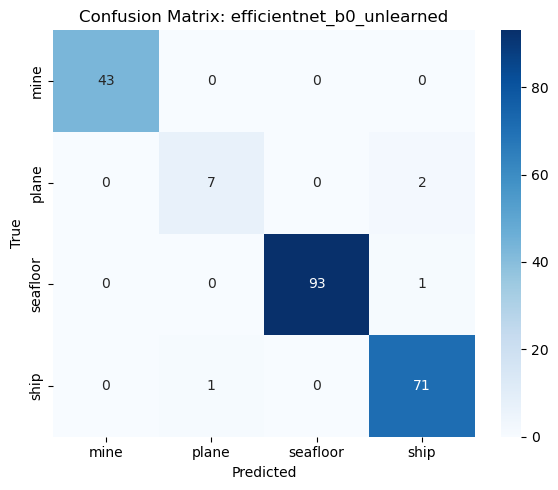

C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\T1_Machine\AppData\Local\Temp\ipykernel_6116\2233540322.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future relea


🧠 efficientnet_b0 (Baseline)
🧠 Predicted: plane (87.39%)

🧠 efficientnet_b0 (Unlearned)
🧠 Predicted: plane (99.80%)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

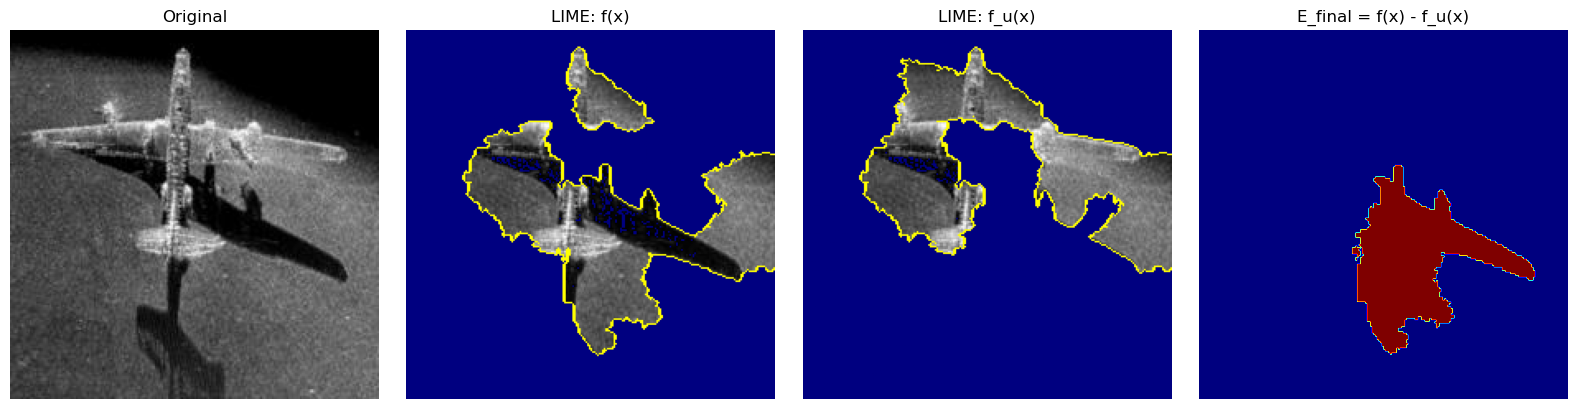

In [48]:
# ✅ Define your backbones
model_names = ["efficientnet_b0"]

# ✅ Your test image path
test_image_path = r"D:\datasets\Reduced_Dataset_600\plane\shuffled_28_1 (1385).jpg"

# ✅ Loop through each model
for model_name in model_names:
    print(f"\n🔁 Processing Backbone: {model_name.upper()}")

    # 1️⃣ Train Triplet-Based Unlearning Model
    model_unlearned = train_unlearning_model(model_name, num_epochs=20)

    # 2️⃣ Evaluate and show classification report + confusion matrix
    evaluate_unlearned(model_unlearned, model_name)

    # 3️⃣ Run LIME-based visual explanation and E_final
    run_full_explanation(test_image_path, model_name)
